# Homework 7 : Linear / Nonlinear Classification

Each subproblem in Problems 1 and 2 is worth 10 pts.  Problems 3 and 4 are worth 15 points each. All cells are marked with instructions to insert your code.  Please complete all cells as directed.

**What to turn in**:
 -  Please print the notebook containing the answers and results into a pdf file (you can use `File - Print`). Submit this pdf file to the main homework entry in gradescope. Be sure to locate your answers for each problem when you submit, as ususal. In the worst case where you cannot print it into a pdf file somehow, you can create a Microsoft word document and then copy-paste screenshots showing your code and output parts by parts.
 -  You also need to submit this jupyter notebook file filled with your answers in the code entry in gradescope.

**Description**:
This homework will study 3-class classification in  the famous "Iris" dataset.  The dataset was introduced by the British statistician and biologist Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems" as an example of linear discriminant analysis. The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, Fisher developed a linear classifier to distinguish the species from each other. We will do the same using classifiers that we have learned.


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import warnings
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.columns import Columns
from rich import print
from sklearn.metrics import confusion_matrix, classification_report

# Suppress warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

## Problem 1 : Load / Explore Data

### (a)

Because this dataset is so well-known, Scikit-Learn includes a special function for loading it, which is provided below.  Do the following in the cell below:
  * Load the data and create a Train / Test split with 25% test data (train_test_split() function)
  * For the above, make sure to use the provided random state so that results are repeatable
  * Display the training inputs (you can use function display())

Note: You will need the feature names later on.  It is helpful at this point to store them in a set using the DataFrame.colums property.

In [2]:
# use this random state for train/test split
random_state = 1234

iris = datasets.load_iris(as_frame=True)
X = iris.data
y = iris.target

# Create a Train / Test split with 25% test data
X_train, X_test = train_test_split(X, test_size=0.25, random_state=random_state)
y_train, y_test = train_test_split(y, test_size=0.25, random_state=random_state)

# Store the feature names for use later on
x_feature_names = X_train.columns

# Display the training inputs
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
22,4.6,3.6,1.0,0.2
93,5.0,2.3,3.3,1.0
36,5.5,3.5,1.3,0.2
68,6.2,2.2,4.5,1.5
32,5.2,4.1,1.5,0.1


### (b)

Now we will explore our feature distributions.  In the cell below, use the Pandas DataFrame plot feature to plot the density of each feature in the training data.

[ Documentation - Pandas - DataFrame.plot ](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

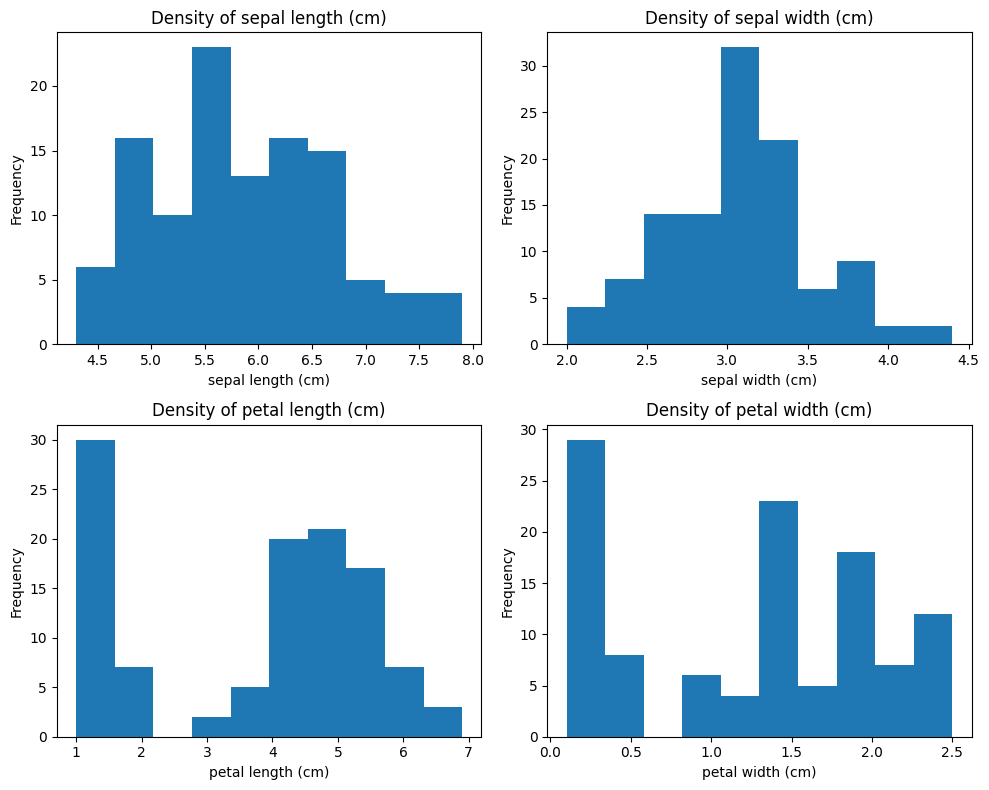

In [3]:
# Create a 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Iterate through the features and plot each in a separate histogram subplot
for ax, feature in zip(axes.flatten(), x_feature_names):
    X_train[feature].plot(kind='hist', title=f'Density of {feature}', ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

plt.tight_layout()


### (c)

Sometimes it is better to look at distributions of each feature plotted together.  In the cell below produce a boxplot (use plt.boxplot()) of each feature in the training data.  **Make sure to rotate X-tick labels 45-degrees so they are readable.**

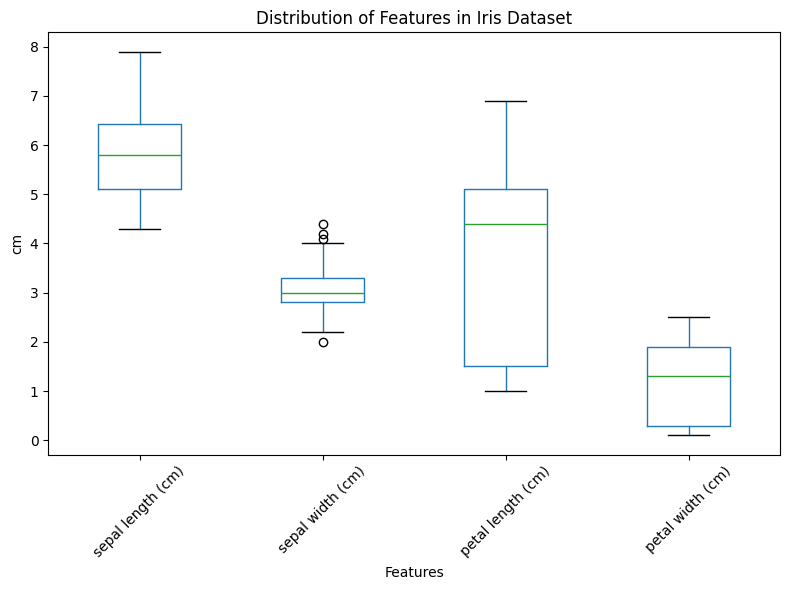

In [4]:
# Create figure containing boxplots for all features together
plt.figure(figsize=(8, 6))
X_train.boxplot(column=list(x_feature_names), grid=False)

# Rotate the x-tick labels for better readability
plt.xticks(rotation=45)

# Set the title and labels
plt.title("Distribution of Features in Iris Dataset")
plt.ylabel("cm")
plt.xlabel("Features")
plt.tight_layout()

### (d)

Now let's see how well we can separate classes from each pair of features.  In the cell below produce a scatterplot of **every pair of features** in the training data.  There will be 6 scatterplots in all.  Make sure to follow these instructions:
  * Color each marker red, green, or blue depending on the true class label
  * Use numpy.corrcoef to compute the correlation coefficient of each feature
  * Title each plot with the correlation coefficient
  * Label each axis using the corresponding feature name

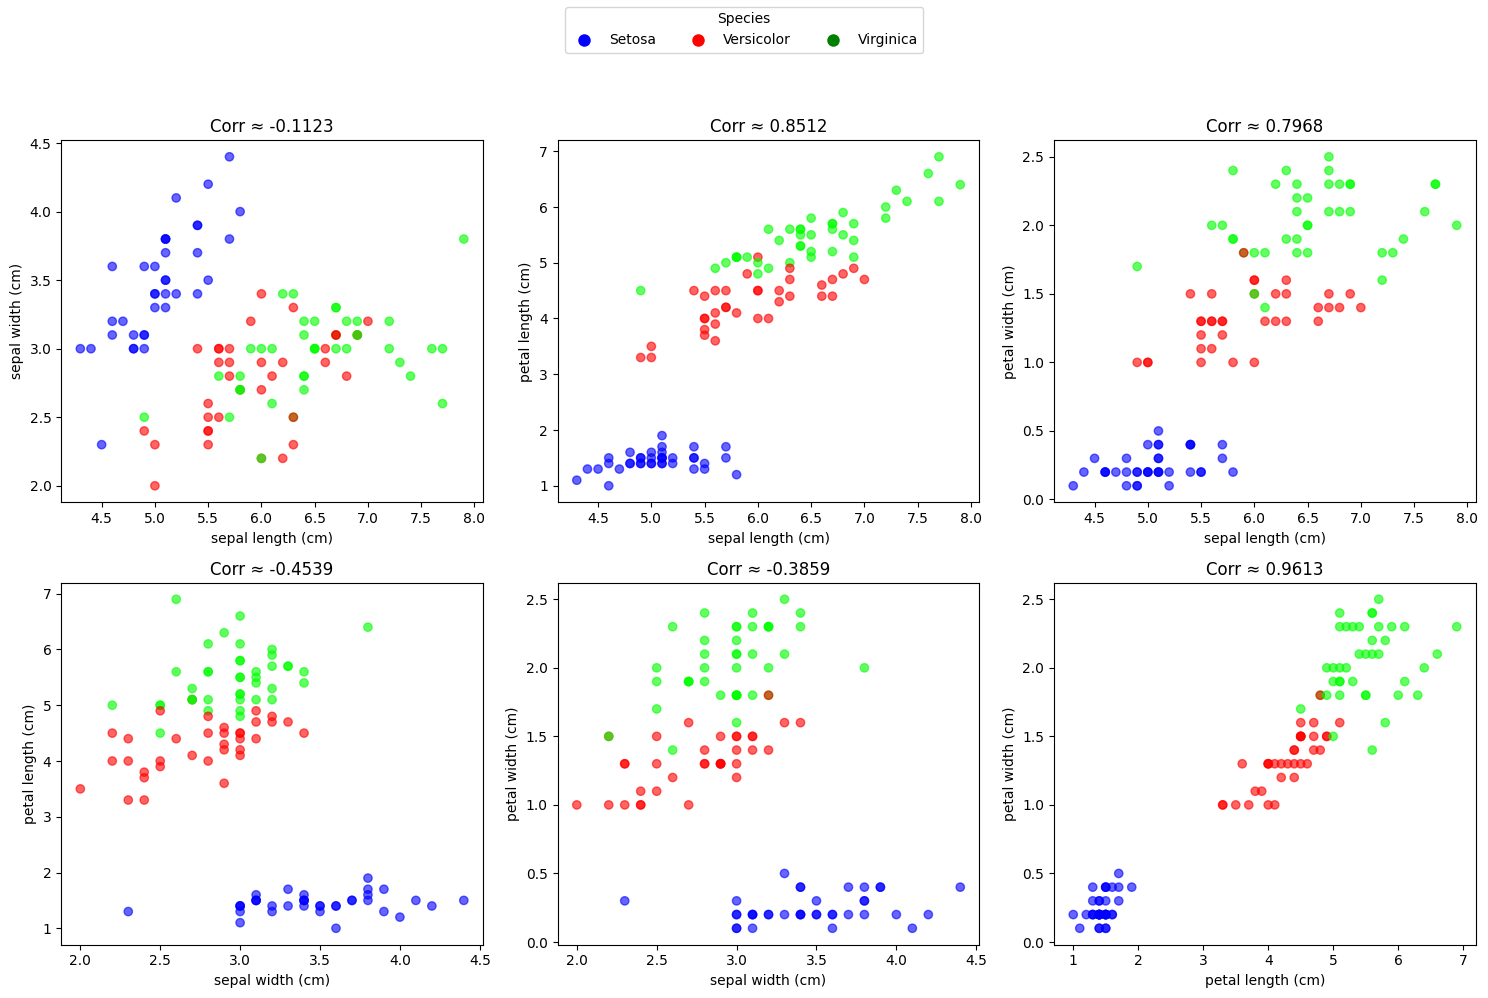

In [5]:
import itertools

# Generate all combinations of two features
twoary_feature_combos = list(itertools.combinations(X_train.columns, 2))

# Create a figure to contain all subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2x3 grid for 6 scatterplots

# Iterate over feature combinations and corresponding axes
for ax, (feature_x, feature_y) in zip(axes.flatten(), twoary_feature_combos):
    scatter = ax.scatter(
        X_train[feature_x], X_train[feature_y], c=y_train, cmap="brg", alpha=0.6
    )
    corr = np.corrcoef(X_train[feature_x], X_train[feature_y])[0, 1]
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.set_title(f"Corr ≈ {corr:.4f}")  # Rounded to 4 decimal places

# Create a legend for the species categories
legend_labels = {0: "Setosa", 1: "Versicolor", 2: "Virginica"}
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=legend_labels[i],
        markersize=10,
        markerfacecolor=color,
    )
    for i, color in enumerate(["blue", "red", "green"])
]

# Add legend to the figure
fig.legend(handles=handles, title="Species", loc="upper center", ncol=3)

# Adjust layout to make room for the legend above the plots
plt.tight_layout(
    rect=[0, 0, 1, 0.9]
)  # Reduce space for subplots to accommodate the legend

## Problem 2 : Train a logistic regression classifier

### (a)

Now we will look at finding the best feature out of all the features. To do this, you will preform Cross Validation of Logustic Regression. We will break this into subproblems to walk through it. In the cell do the following:
* Using LogisticRegressionCV perform 5-fold cross validation to train on each feature
* For each run use Matplotlib errorbar() to plot the average +/- standard deviation of error versus regularization coefficient (the property LogisticRegressionCV.Cs_) -- there should be 4 plots in total
* Set plot X-label with the feature name, and Y-label "Accuracy"
* Title each plot with the maximum achieved accuracy score
* Report the best accuracy from cross-validation
* Finally, report the best performing feature and save it for later

Make sure to set the following properties in LogisticRegressionCV:
* cv=5
* max_iter=1e4
* random_state=0
* multi_class='multinomial'
* Cs=10

[Documentation - Scikit-Learn - LogisticRegressionCV](https://scikit-learn.org/0.16/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

Best performing feature:          petal width (cm)
With accuracy:                    0.9640
Using Regularization Coefficient: 2.7826e+00


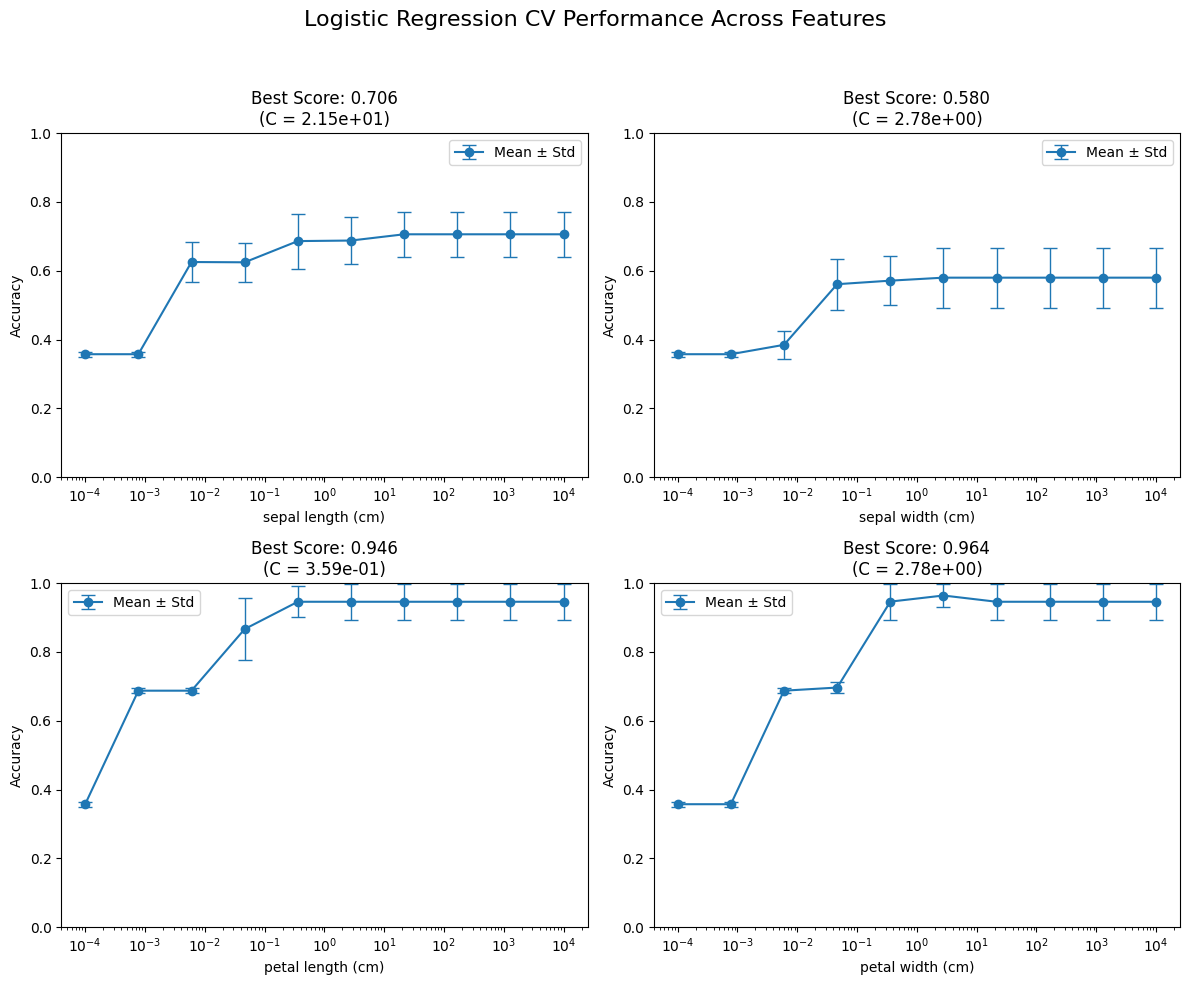

In [6]:
# Create a figure to contain all subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(
    "Logistic Regression CV Performance Across Features",
    fontsize=16,
)

lr_hyperparams = {
    "cv": 5,
    "max_iter": int(1e4),
    "random_state": 0,
    "multi_class": "multinomial",
    "Cs": 10,
}
best_feature: list[str, float, float] = [
    None,
    float("-inf"),
    None,
]  # feature, accuracy, reg coeff

for ax, feature in zip(axes.flatten(), X_train.columns):
    # Fit the model on the feature
    lr = LogisticRegressionCV(**lr_hyperparams)
    lr.fit(X_train[[feature]], y_train)

    regularization_coeffs = lr.Cs_

    # From scikit docs:
    #   "If the ‘multi_class’ option given is ‘multinomial’ then the same scores are repeated across all
    #    classes, since this is the multinomial class. Each dict value has shape (n_folds, len(Cs))."
    # Thus, we can just use the first item in the scores_ array since they are all the same
    scores = lr.scores_[0]
    mean_scores = scores.mean(axis=0)
    std_scores = scores.std(axis=0)

    # Find the best score and the corresponding regularization coefficient
    best_score_idx_svm = mean_scores.argmax()
    best_score_all_feat = mean_scores[best_score_idx_svm]
    best_coeff_svm = regularization_coeffs[best_score_idx_svm]
    if best_score_all_feat > best_feature[1]:
        best_feature = [feature, best_score_all_feat, best_coeff_svm]

    # Plot the average +/- standard deviation using error bars
    ax.errorbar(
        regularization_coeffs,
        mean_scores,
        yerr=std_scores,
        fmt="o-",
        capsize=5,
        elinewidth=1,
        label="Mean ± Std",
    )

    ax.set_xscale("log")  # Plot regularization coefficients on log scale
    ax.set_xlabel(f"{feature}")  # Set x-label to feature name (per instructions)
    ax.set_ylabel("Accuracy")
    ax.set_ylim(
        0, 1
    )  # Set y-scale between 0 and 1 so all features can be fairly compared on same scale
    ax.set_title(f"Best Score: {best_score_all_feat:.3f}\n(C = {best_coeff_svm:.2e})")
    ax.legend()

# Report the best accuracy and best performing feature from cross-validation
print(
    f"Best performing feature:          {best_feature[0]}",
    f"With accuracy:                    {best_feature[1]:.4f}",
    f"Using Regularization Coefficient: {best_feature[2]:.4e}",
    sep="\n",
)

plt.tight_layout(rect=[0, 0, 1, 0.95])

### (b)

Now lets look at all pairs of features.  The cell below provides a function plotLogreg2feat() to visualize the learned classifier for a pair of features.  This function will draw the decision boundaries for each of the three classes, which will give us a better picture of what's going on.  In the cell below that do the following:
* Loop over every pair of features (there are 6 pairs total)
* Using LogisticRegressionCV perform 5-fold cross validation to train a classifier on the pair of features
* Make sure to use **the same cross validation options as the previous experiment**
* Using plotLogreg2feat plot the learned classifier
* Title each plot with the maximum average accuracy from cross validation

In [7]:
def plotLogreg2feat(X, featname_1, featname_2, model):
    '''
    INPUTS:
      X - Input DataFrame (assumes Nx2 for N data points and 2 features)
      featname_1, featname_2 - String containing feature names
      model - Fitted LogisticRegressionCV model

    OUTPUTS:
      ax - Returns figure axis object
    '''

    # make grid
    x_min, x_max = X[featname_1].min() - 0.5*X[featname_1].std(), X[featname_1].max() + 0.5*X[featname_1].std()
    y_min, y_max = X[featname_2].min() - 0.5*X[featname_2].std(), X[featname_2].max() + 0.5*X[featname_2].std()
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #plt.figure(1, figsize=(4, 3))
    # fig, ax = plt.subplots()
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    #plt.scatter(X_train[features[i]][ Y_train == 0 ], X_train[features[j]][ Y_train == 0 ], c='r')
    #plt.scatter(X_train[features[i]][ Y_train == 1 ], X_train[features[j]][ Y_train == 1 ], c='g')
    #plt.scatter(X_train[features[i]][ Y_train == 2 ], X_train[features[j]][ Y_train == 2 ], c='b')

    ax.scatter(X[featname_1][ y == 0 ], X[featname_2][ y == 0 ], c='r')
    ax.scatter(X[featname_1][ y == 1 ], X[featname_2][ y == 1 ], c='g')
    ax.scatter(X[featname_1][ y == 2 ], X[featname_2][ y == 2 ], c='b')

    ax.set_xlabel(featname_1)
    ax.set_ylabel(featname_2)


    #plt.xlim(xx.min(), xx.max())
    #plt.ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

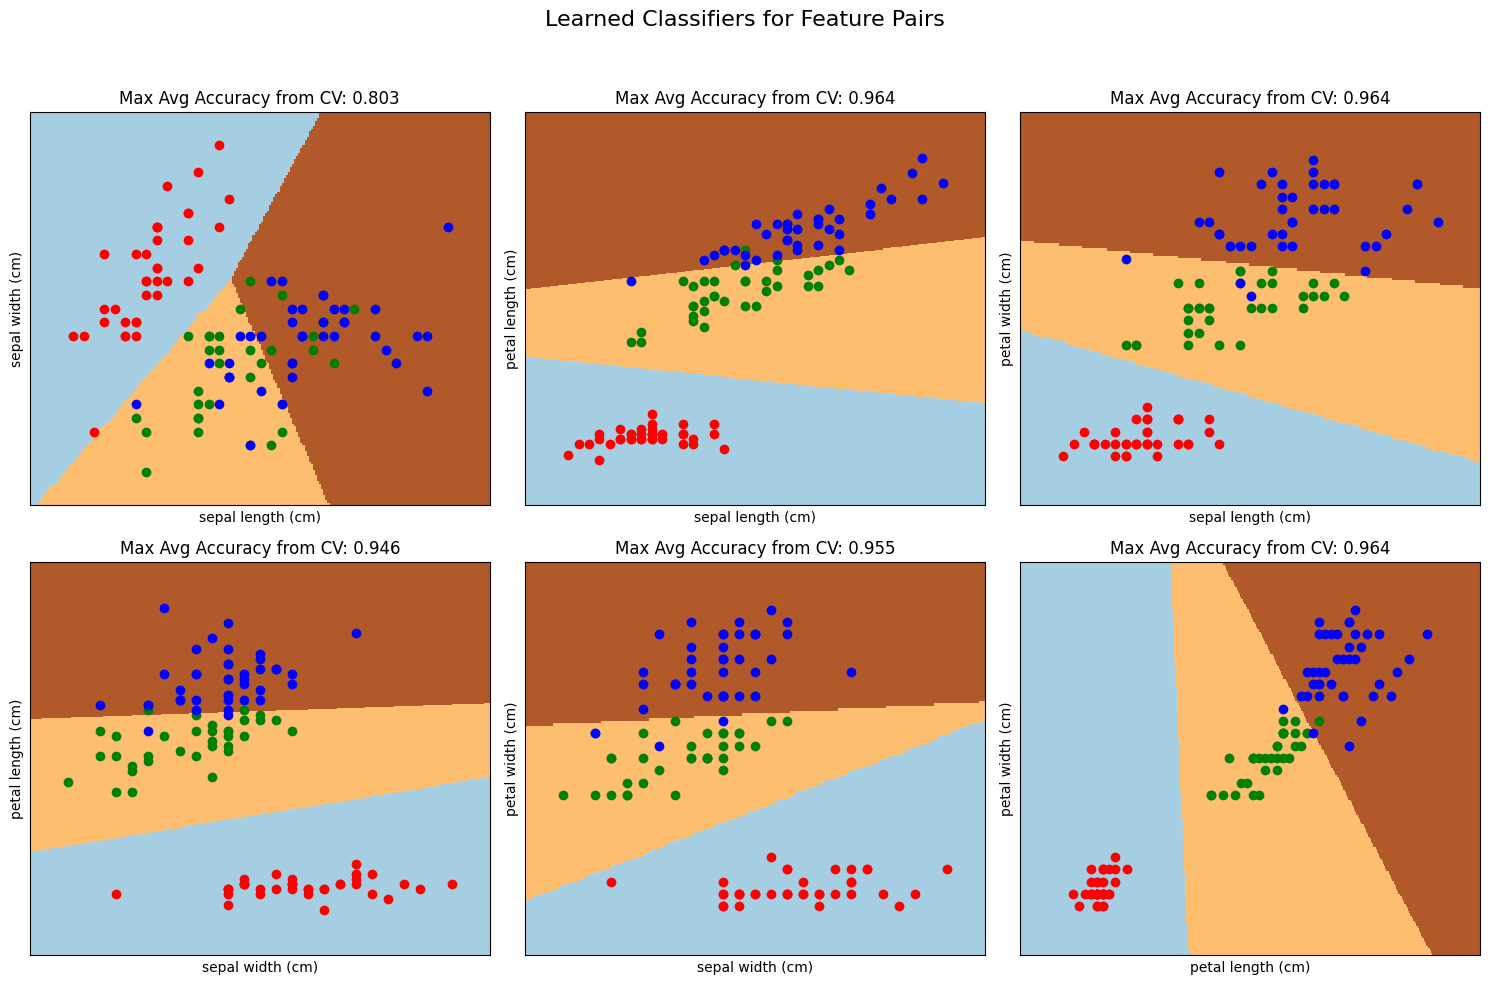

In [8]:
# Generate all combinations of two features
twoary_feature_combos = list(itertools.combinations(X_train.columns, 2))

# Create a figure to contain all subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2x3 grid for 6 plots
fig.suptitle(
    "Learned Classifiers for Feature Pairs",
    fontsize=16,
)

# Track best-performing feature-pair
best_feature_pair: list[list[str, str], float, float] = [
    None,
    float("-inf"),
    None,
]  # (feature, feature), accuracy, reg coeff

# Iterate over feature combinations and corresponding axes
for ax, (feature_x, feature_y) in zip(axes.flatten(), twoary_feature_combos):
    lr = LogisticRegressionCV(**lr_hyperparams)
    lr.fit(X_train[[feature_x, feature_y]], y_train)

    # Plot the learned classifier
    plot = plotLogreg2feat(X_train, feature_x, feature_y, lr)

    # Find the best score and the corresponding regularization coefficient
    mean_scores = lr.scores_[0].mean(axis=0)
    best_idx = mean_scores.argmax()
    best_score = mean_scores[best_idx]
    best_coeff = lr.Cs_[best_idx]
    if best_score > best_feature_pair[1]:
        best_feature_pair = [(feature_x, feature_y), best_score, best_coeff]

    # Determine max average accuracy from cross-validation
    plot.set_title(f"Max Avg Accuracy from CV: {best_score:.3f}")

plt.tight_layout(rect=[0, 0, 1, 0.95])

### (c)

Surprisingly, adding pairs of features doesn't seem to improve things.  Let's try training on all features.  In the cell below:
* Perform 5-fold cross validation (using all the same parameters as before) to train a logistic regression classifier on all features
* Report the maximum of the average scores.

In [9]:
# Perform 5-fold cv to train logistic regression classifier on ALL features
lr_all_feat = LogisticRegressionCV(**lr_hyperparams)
lr_all_feat.fit(X_train, y_train)

# Determine and report max of average accuracy scores during CV
best_score_all_feat = lr.scores_[0].mean(axis=0).max()
all_feat_better = best_score_all_feat > best_feature[2]
print(
    f"When using all 4 features, maximum average accuracy from CV is:\n\t{best_score_all_feat:.3f}",
    f"\n\nIs classifier trained on all features better than classifier trained on best pair of features?\n\t{all_feat_better}",
)

When using all 4 features, maximum average accuracy from CV is:
	0.964 

Is classifier trained on all features better than classifier trained on best pair of features?
	False


If your results are the same as mine, the maximum score over all features is the same as over the best single feature.

## Problem 3 : Support Vector Machine
We have trained several logistic regression classifiers, all of which achieve an a cross-validation accuracy well into the 90% range.  In an effort to see if we can do better, let's train one lass classifier--a support vector machine.  For this classifier we will introduce a nonlinear tranformation using the Radial Basis kernel function.  In the cell be low do the following:
* Using Numpy.logspace create a logarithmically spaced set of 100 regularization coefficient in the range (1e-4, 1e4)
* For each coefficient define a support vector classifier with kernel='rbf' and set the regularization coefficient (C=coefficient)
* Perform 5-fold cross validation (e.g. using cross_val_score)
* Plot the average accuracy versus regularization coefficient and report the maximum accuracy and best coefficient
* Make sure to set the plot X-scale to 'log' and label axes and title

[ Documentation - Scikit-Learn - svm.SVC ](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC.score)

Best Accuracy:                    0.9727
Using Regularization Coefficient: 2.78e+00


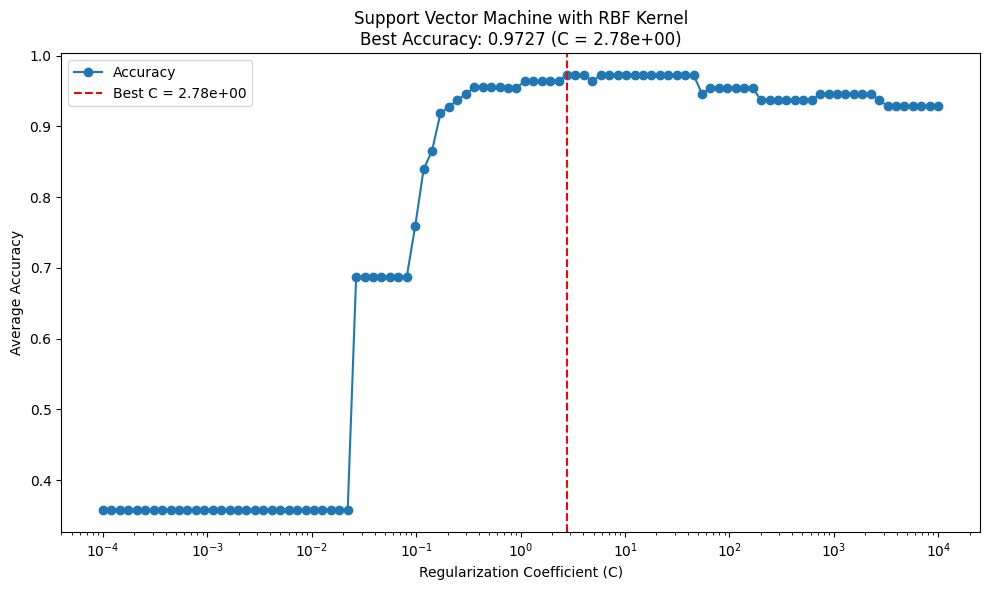

In [10]:
# Create a logarithmically spaced set of 100 regularization coefficients in the range (1e-4, 1e4)
reg_coeff_domain = np.logspace(-4, 4, 100)

# Initialize arrays to store results
svm_scores_per_coeff = np.zeros(len(reg_coeff_domain))

# Construct SVM with RBF kernel Perform 5-fold cross-validation for each coefficient
for idx, coeff in enumerate(reg_coeff_domain):
    classifier = SVC(C=coeff, kernel="rbf")
    svm_scores_per_coeff[idx] = cross_val_score(
        classifier, X_train, y_train, cv=5
    ).mean()

# Find the best accuracy and its corresponding regularization coefficient
best_score_idx_svm = svm_scores_per_coeff.argmax()
best_score_svm = svm_scores_per_coeff[best_score_idx_svm]
best_coeff_svm = reg_coeff_domain[best_score_idx_svm]

# Plot average accuracy versus regularization coefficient
plt.figure(figsize=(10, 6))
plt.plot(
    reg_coeff_domain, svm_scores_per_coeff, marker="o", linestyle="-", label="Accuracy"
)
plt.xscale("log")
plt.xlabel("Regularization Coefficient (C)")
plt.ylabel("Average Accuracy")
plt.title(
    f"Support Vector Machine with RBF Kernel\nBest Accuracy: {best_score_svm:.4f} (C = {best_coeff_svm:.2e})"
)
plt.axvline(
    x=best_coeff_svm,
    color="red",
    linestyle="--",
    label=f"Best C = {best_coeff_svm:.2e}",
)
plt.legend()

# Report the maximum accuracy and best coefficient
print(
    f"Best Accuracy:                    {best_score_svm:.4f}",
    f"Using Regularization Coefficient: {best_coeff_svm:.2e}",
    sep="\n",
)

plt.tight_layout()

My results show slightly higher accuracy under the SVM classifier.  However, cross_val_score does not use the same cross validation splits as the built-in cross validation of LogisticRegressionCV (which randomizes splits).  So we shall see...

## Problem 4 : Evaluate on test
Now we will evaluate all classifiers on the test data.  Take the best regression classifier and the best SVM classifier (with previously chosen parameters), train them, and evaluate accordingly.  For each classifier report:
  * Test accuracy
  * Confusion matrix
  * Results of classification_report
  
We have only left a single cell below.  Feel free to insert additional cells and arrange output as you see fit.  Make sure it is readable.  Feel free to explore any additional visualizations or metrics.

Function to display standardized model evaluation report for each classifier:

In [11]:
def display_model_evaluation(
    y_true, y_pred, features, model_type, training_accuracy, regularization_coeff
):
    """
    Displays a consolidated panel with model summary and confusion matrix/classification report side-by-side using rich.
    """
    console = Console()
    class_names = ["Setosa", "Versicolor", "Virginica"]
    feature_list = ", ".join(features)
    model_summary = (
        f"[bold]Model Type:[/bold]                  {model_type}\n"
        f"[bold]Features Used:[/bold]               {feature_list}\n"
        f"[bold]Regularization Coefficient:[/bold]  {regularization_coeff:.2e}\n"
        f"[bold]Accuracy on Training Data:[/bold]   {training_accuracy:.3f}\n"
        f"\n[bold yellow]Note:[/bold yellow] Above metrics are based on CV on training data. Below metrics are based on evaluation on test data."
    )

    # Classification Report
    class_report = classification_report(
        y_true, y_pred, target_names=class_names, digits=2
    )
    classification_report_section = Panel(
        f"[bold green]Classification Report[/bold green]\n\n{class_report}",
        title="Classification Report",
        expand=True,
    )

    # Confusion Matrix as Formatted String
    conf_matrix = confusion_matrix(y_true, y_pred)
    column_width = max(len(cls) for cls in class_names) + 2
    header = "".join(f"{cls:<{column_width}}" for cls in [""] + class_names)
    rows = "\n".join(
        f"{class_names[i]:<{column_width}}"
        + "".join(f"{val:<{column_width}}" for val in row)
        for i, row in enumerate(conf_matrix)
    )
    conf_matrix_section = Panel(
        f"[bold cyan]Confusion Matrix[/bold cyan]\n\n{header}\n{rows}",
        title="Confusion Matrix",
        expand=True,
    )

    # Combine confusion matrix and classification report side-by-side
    side_by_side_content = Columns([conf_matrix_section, classification_report_section])

    # Combine everything into a single panel
    console.print(Panel(model_summary, title="Model Summary", expand=True))
    console.print(side_by_side_content)

### Evaluate Best Single-Feature Regression Classifier

In [12]:
feat_name, train_acc, coeff = best_feature

# Train the Logistic Regression classifier with best feature and associated best coefficient
best_single_feat_lr = LogisticRegression(
    C=coeff, multi_class="multinomial", max_iter=int(1e4)
)
best_single_feat_lr.fit(X_train[[feat_name]], y_train)

# Make predictions on the test data
single_feat_preds = best_single_feat_lr.predict(X_test[[feat_name]])

# Display report on model
display_model_evaluation(
    y_test, single_feat_preds, [feat_name], "Logistic Regression", train_acc, coeff
)

╭───────────────────────────────────────────────── Model Summary ─────────────────────────────────────────────────╮
│ Model Type:                  Logistic Regression                                                                │
│ Features Used:               petal width (cm)                                                                   │
│ Regularization Coefficient:  2.78e+00                                                                           │
│ Accuracy on Training Data:   0.964                                                                              │
│                                                                                                                 │
│ Note: Above metrics are based on CV on training data. Below metrics are based on evaluation on test data.       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────── Confusion Matrix ────────────────╮ ╭──────────────── Classification Report ────────────────╮
│ Confusion Matrix                                 │ │ Classification Report                                 │
│                                                  │ │                                                       │
│             Setosa      Versicolor  Virginica    │ │               precision    recall  f1-score   support │
│ Setosa      13          0           0            │ │                                                       │
│ Versicolor  0           14          1            │ │       Setosa       1.00      1.00      1.00        13 │
│ Virginica   0           1           9            │ │   Versicolor       0.93      0.93      0.93        15 │
╰──────────────────────────────────────────────────╯ │    Virginica       0.90      0.90      0.90        10 │
                                                     │                                                       │
                                                     │     accuracy                           0.95        38 │
                                                     │    macro avg       0.94      0.94      0.94        38 │
                                                     │ weighted avg       0.95      0.95      0.95        38 │
                                                     │                                                       │
                                                     ╰───────────────────────────────────────────────────────╯

### Evaluate Best Feature-Pair Regression Classifier

In [13]:
feats, train_acc, coeff = best_feature_pair

# Train the Logistic Regression classifier with best feature and associated best coefficient
best_pair_lr = LogisticRegression(C=coeff, multi_class="multinomial", max_iter=int(1e4))
best_pair_lr.fit(X_train[list(feats)], y_train)

# Make predictions on the test data
best_pair_preds = best_pair_lr.predict(X_test[list(feats)])

# Display report on model
display_model_evaluation(
    y_test, best_pair_preds, feats, "Logistic Regression", train_acc, coeff
)

╭───────────────────────────────────────────────── Model Summary ─────────────────────────────────────────────────╮
│ Model Type:                  Logistic Regression                                                                │
│ Features Used:               sepal length (cm), petal width (cm)                                                │
│ Regularization Coefficient:  2.78e+00                                                                           │
│ Accuracy on Training Data:   0.964                                                                              │
│                                                                                                                 │
│ Note: Above metrics are based on CV on training data. Below metrics are based on evaluation on test data.       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────── Confusion Matrix ────────────────╮ ╭──────────────── Classification Report ────────────────╮
│ Confusion Matrix                                 │ │ Classification Report                                 │
│                                                  │ │                                                       │
│             Setosa      Versicolor  Virginica    │ │               precision    recall  f1-score   support │
│ Setosa      13          0           0            │ │                                                       │
│ Versicolor  0           14          1            │ │       Setosa       1.00      1.00      1.00        13 │
│ Virginica   0           1           9            │ │   Versicolor       0.93      0.93      0.93        15 │
╰──────────────────────────────────────────────────╯ │    Virginica       0.90      0.90      0.90        10 │
                                                     │                                                       │
                                                     │     accuracy                           0.95        38 │
                                                     │    macro avg       0.94      0.94      0.94        38 │
                                                     │ weighted avg       0.95      0.95      0.95        38 │
                                                     │                                                       │
                                                     ╰───────────────────────────────────────────────────────╯

### Evaluate All-Feature SV Classifier

In [14]:
# Train the Logistic Regression classifier with best feature and associated best coefficient
best_svm = SVC(C=best_coeff_svm, kernel="rbf")
best_svm.fit(X_train, y_train)

# Make predictions on the test data
best_svm_preds = best_svm.predict(X_test)

# Display report on model
display_model_evaluation(
    y_test,
    best_svm_preds,
    x_feature_names,
    "Support Vector",
    best_score_svm,
    best_coeff_svm,
)

╭───────────────────────────────────────────────── Model Summary ─────────────────────────────────────────────────╮
│ Model Type:                  Support Vector                                                                     │
│ Features Used:               sepal length (cm), sepal width (cm), petal length (cm), petal width (cm)           │
│ Regularization Coefficient:  2.78e+00                                                                           │
│ Accuracy on Training Data:   0.973                                                                              │
│                                                                                                                 │
│ Note: Above metrics are based on CV on training data. Below metrics are based on evaluation on test data.       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────── Confusion Matrix ────────────────╮ ╭──────────────── Classification Report ────────────────╮
│ Confusion Matrix                                 │ │ Classification Report                                 │
│                                                  │ │                                                       │
│             Setosa      Versicolor  Virginica    │ │               precision    recall  f1-score   support │
│ Setosa      13          0           0            │ │                                                       │
│ Versicolor  0           14          1            │ │       Setosa       1.00      1.00      1.00        13 │
│ Virginica   0           0           10           │ │   Versicolor       1.00      0.93      0.97        15 │
╰──────────────────────────────────────────────────╯ │    Virginica       0.91      1.00      0.95        10 │
                                                     │                                                       │
                                                     │     accuracy                           0.97        38 │
                                                     │    macro avg       0.97      0.98      0.97        38 │
                                                     │ weighted avg       0.98      0.97      0.97        38 │
                                                     │                                                       │
                                                     ╰───────────────────────────────────────────────────────╯